# Modeling and Simulation in Python

Case study: Throwing Axe

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### Throwing axe

Our favorite event at Lumberjack Competitions is axe throwing.  The axes used for this event typically weigh 1.5 to 2 kg, with handles roughly 0.7 m long.  They are thrown overhead at a target typically 6 m away and 1.5 m off the ground.  Normally, the axe makes one full rotation in the air to hit the target blade first, with the handle close to vertical.

![Diagram of throwing axe](diagrams/throwingaxe1.png)

Here's a version of `make_system` that sets the initial conditions.

The state variables are x, y, theta, vx, vy, omega, where theta is the orientation (angle) of the axe in radians and omega is the angular velocity in radians per second.

I chose initial conditions based on videos of axe throwing.

In [2]:
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram
radian = UNITS.radian

def make_system():
    """Makes a System object for the given conditions.
    
    returns: System with init, ...
    """
    P = Vector(0, 2) * m
    V = Vector(8, 4) * m/s
    theta = 2 * radian
    omega = -7 * radian/s
    
    init = State(P=P, V=V, theta=theta, omega=omega)

    t_end = 1.0 * s
    
    return System(init=init, t_end=t_end,
                  g = 9.8 * m/s**2,
                  mass = 1.5 * kg,
                  length = 0.7 * m)

Let's make a `System`

In [3]:
system = make_system()

,values
init,"P [0.0 meter, 2.0 met..."
t_end,1.0 second
g,9.8 meter / second ** 2
mass,1.5 kilogram
length,0.7 meter


In [4]:
system.init

,values
P,"[0.0 meter, 2.0 meter]"
V,"[8.0 meter / second, 4.0 meter / second]"
theta,2 radian
omega,-7.0 radian / second


As a simple starting place, I ignore drag, so `vx` and `omega` are constant, and `ay` is just `-g`.

In [5]:
def slope_func(state, t, system):
    """Computes derivatives of the state variables.
    
    state: State (x, y, x velocity, y velocity)
    t: time
    system: System object with length0, m, k
    
    returns: sequence (vx, vy, ax, ay)
    """
    P, V, theta, omega = state

    A = Vector(0, -system.g)
    alpha = 0 * radian / s**2

    return V, A, omega, alpha

As always, let's test the slope function with the initial conditions.

In [6]:
slope_func(system.init, 0, system)

(array([8., 4.]) <Unit('meter / second')>,
 array([ 0. , -9.8]) <Unit('meter / second ** 2')>,
 -7.0 <Unit('radian / second')>,
 0.0 <Unit('radian / second ** 2')>)

And then run the simulation.

In [7]:
results, details = run_ode_solver(system, slope_func)
details

,values
success,True
message,The solver successfully reached the end of the...


In [8]:
results.tail()

,P,V,theta,omega
0.96,"[7.680000000000005 meter, 1.3241600000000022 m...","[8.0 meter / second, -5.407999999999994 meter ...",-4.7200000000000015 radian,-7.0 radian / second
0.97,"[7.760000000000005 meter, 1.2695900000000022 m...","[8.0 meter / second, -5.505999999999994 meter ...",-4.790000000000002 radian,-7.0 radian / second
0.98,"[7.840000000000005 meter, 1.2140400000000022 m...","[8.0 meter / second, -5.603999999999994 meter ...",-4.860000000000002 radian,-7.0 radian / second
0.99,"[7.920000000000005 meter, 1.1575100000000023 m...","[8.0 meter / second, -5.701999999999994 meter ...",-4.930000000000002 radian,-7.0 radian / second
1.00,"[8.000000000000005 meter, 1.1000000000000023 m...","[8.0 meter / second, -5.799999999999994 meter ...",-5.000000000000003 radian,-7.0 radian / second


### Visualizing the results

The simplest way to visualize the results is to plot the state variables as a function of time.

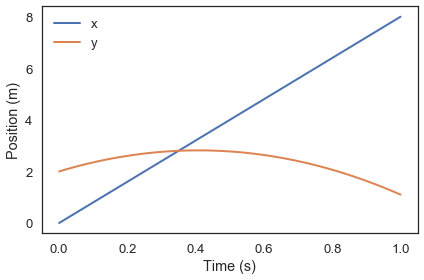

In [9]:
def plot_position(P):
    x = P.extract('x')
    y = P.extract('y')
    plot(x, label='x')
    plot(y, label='y')

    decorate(xlabel='Time (s)',
             ylabel='Position (m)')
    
plot_position(results.P)

We can plot the velocities the same way.

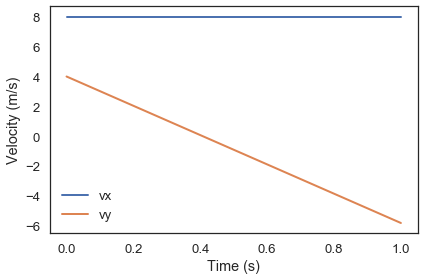

In [10]:
def plot_velocity(V):
    vx = V.extract('x')
    vy = V.extract('y')
    plot(vx, label='vx')
    plot(vy, label='vy')

    decorate(xlabel='Time (s)',
             ylabel='Velocity (m/s)')
    
plot_velocity(results.V)

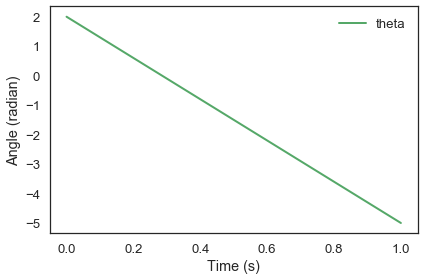

In [11]:
plot(results.theta, label='theta', color='C2')

decorate(xlabel='Time (s)',
         ylabel='Angle (radian)')

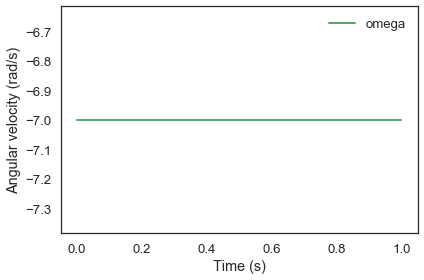

In [12]:
plot(results.omega, label='omega', color='C2')

decorate(xlabel='Time (s)',
         ylabel='Angular velocity (rad/s)')

Another way to visualize the results is to plot y versus x.  The result is the trajectory through the plane of motion.

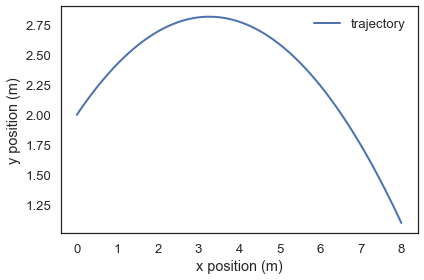

In [13]:
def plot_trajectory(P, **options):
    x = P.extract('x')
    y = P.extract('y')
    plot(x, y, **options)
    
    decorate(xlabel='x position (m)',
             ylabel='y position (m)')
    
plot_trajectory(results.P, label='trajectory')

## Animation

Animating this system is a little more complicated, if we want to show the shape and orientation of the axe.

It is useful to construct a frame with $\hat{r}$ along the handle of the axe and $\hat{\theta}$ perpendicular.

Now we're ready to animate the results.  The following figure shows the frame and the labeled points A, B, C, and D.

![Diagram of the axe with reference frame](diagrams/throwingaxe2.png)

In [14]:
def make_frame(theta):
    rhat = Vector(pol2cart(theta, 1))
    that = rhat.perp()
    return rhat, that

In [15]:
P, V, theta, omega = results.first_row()
rhat, that = make_frame(theta)

In [16]:
rhat

array([-0.41614684,  0.90929743]) <Unit('dimensionless')>

In [17]:
that

array([-0.90929743, -0.41614684]) <Unit('dimensionless')>

In [18]:
np.dot(rhat, that)

0.0 <Unit('dimensionless')>

(-0.9547622981669658,
 0.04546487134128409,
 -0.48241904971578364,
 0.9755696399943229)

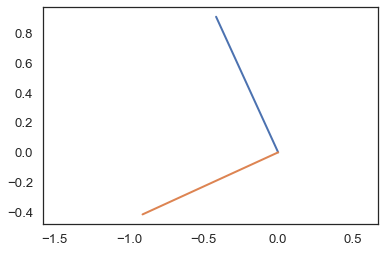

In [19]:
O = Vector(0, 0)
plot_segment(O, rhat)
plot_segment(O, that)
plt.axis('equal')

In [23]:
xs = results.P.extract('x')
ys = results.P.extract('y')

l1 = 0.6 * m
l2 = 0.1 * m

def draw_func(state, t):
    plt.axis('equal')
    set_xlim([0,8])
    set_ylim([0,6])
    
    P, V, theta, omega = state
    rhat, that = make_frame(theta)
    
    # plot the handle
    A = P - l1 * rhat
    B = P + l2 * rhat
    plot_segment(A, B, color='red')

    # plot the axe head
    C = B + l2 * that
    D = B - l2 * that
    plot_segment(C, D, color='black', linewidth=10)

    # plot the COG
    x, y = P
    plot(x, y, 'bo')

    decorate(xlabel='x position (m)',
             ylabel='y position (m)')

During the animation, the parts of the axe seem to slide around relative to each other.  I think that's because the lines and circles get rounded off to the nearest pixel.

Here's the final state of the axe at the point of impact (assuming the target is 8 m away).

In [24]:
state = results.first_row()

,values
P,"[0.0 meter, 2.0 meter]"
V,"[8.0 meter / second, 4.0 meter / second]"
theta,2 radian
omega,-7.0 radian / second


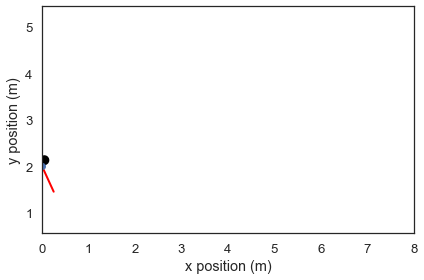

In [25]:
draw_func(state, 0)

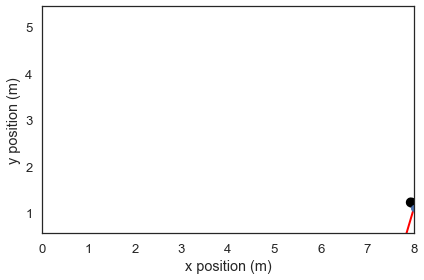

In [26]:
animate(results, draw_func)

## Exercises

**Exercise:**  Find the starting conditions that make the final height of the COG as close as possible to 1.5 m.  Ideally, the final angle should be a little past vertical.